# Bike sharing demand forecast (on daily data)

Predict bike sharing demand as a function of seasonal and weather conditions.

Data origin:
- original full dataset (by hour, not used here): https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
- simplified dataset (by day, with some simple scaling): https://www.hds.utc.fr/~tdenoeux/dokuwiki/en/aec
    - description: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/exam_2019_ace_.pdf
    - data: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/bike_sharing_day.csv.zip
    
Note that even if we are estimating a time serie, we are not using here a recurrent neural network as we assume the temporal dependence to be negligible (i.e. Y_t = f(X_t) alone).

In [1]:
using Pkg
function addIfNeeded(pkgs...)
    isinstalled(pkg::String) = any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
    [Pkg.add(pkg) for pkg in pkgs  if !isinstalled(pkg)]
end

addIfNeeded("DataFrames","CSV","StatsPlots","Distributions","DecisionTree","BetaML")


using LinearAlgebra, Random, DataFrames, CSV, StatsPlots, BetaML.Trees, DecisionTree
import Distributions: Uniform

import Random:seed!
seed!(123);

In [2]:
using BetaML  # only needed to get the relative path in importing data
baseDir = joinpath(dirname(pathof(BetaML)),"..","notebooks","assets","bikeSharingDemandForecast")

"/home/lobianco/.julia/dev/BetaML/src/../notebooks/assets/bikeSharingDemandForecast"

In [3]:
# Data loading and cleaning..
data = CSV.File(joinpath(baseDir,"bike_sharing_day.csv"),delim=',') |> DataFrame
describe(data)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,instant,366.0,1,366.0,731,0,Int64
2,dteday,,2011-01-01,,2012-12-31,0,Date
3,season,2.49658,1,3.0,4,0,Int64
4,yr,0.500684,0,1.0,1,0,Int64
5,mnth,6.51984,1,7.0,12,0,Int64
6,holiday,0.0287278,0,0.0,1,0,Int64
7,weekday,2.99726,0,3.0,6,0,Int64
8,workingday,0.683995,0,1.0,1,0,Int64
9,weathersit,1.39535,1,1.0,3,0,Int64


In [4]:
# Split the data in training/testing sets
x    = convert(Matrix,hcat(data[:,[:instant,:season,:yr,:mnth,:holiday,:weekday,:workingday,:weathersit,:temp,:atemp,:hum,:windspeed]]))
y    = data[:,16] 

((xtrain,xval,xtest),(ytrain,yval,ytest)) = BetaML.Utils.partition([x,y],[0.75,0.125,1-0.75-0.125],shuffle=false)
(ytrain,yval,ytest)  = dropdims.([ytrain,yval,ytest],dims=2)
(ntrain, nval, ntest) = size.([ytrain,yval,ytest],1)

3-element Array{Int64,1}:
 548
  92
  91

## Decision Trees

In [5]:
function findBestDepth(xtrain,ytrain,xval,yval,atteptedDepths)
    bestDepth = 1
    bestMre   = +Inf
    for ad in atteptedDepths
        myTree = buildTree(xtrain,ytrain, max_depth=ad)
        ŷval   = Trees.predict(myTree, xval)
        mreVal = relative_mean_error(ŷval,yval)
        println("$ad : $mreVal")
        if mreVal < bestMre
            bestDepth = ad
            bestMre   = mreVal
        end
    end
    return (bestDepth, bestMre)
end

findBestDepth (generic function with 1 method)

In [6]:
bestDepth, bestMre = findBestDepth(xtrain,ytrain,xval,yval,1:20)

1 : 0.4127309388709772
2 : 0.2794301077054831
3 : 0.13362485909754848
4 : 0.11454482775124314
5 : 0.09728806010291896
6 : 0.11609213848432307
7 : 0.12377200531517558
8 : 0.12005843565956463
9 : 0.1227278195119883
10 : 0.11970535865547828
11 : 0.1294032976974931
12 : 0.12830418532233723
13 : 0.128754673021293
14 : 0.12773683067799474
15 : 0.12773683067799474
16 : 0.12773683067799474
17 : 0.12773683067799474
18 : 0.12773683067799474
19 : 0.12773683067799474
20 : 0.12773683067799474


(5, 0.09728806010291896)

In [7]:
myTree = buildTree(xtrain,ytrain, max_depth=bestDepth)

BetaML.Trees.DecisionNode{Float64}(BetaML.Trees.Question{Float64}(9, 0.433913), BetaML.Trees.DecisionNode{Float64}(BetaML.Trees.Question{Float64}(1, 433.0), BetaML.Trees.DecisionNode{Float64}(BetaML.Trees.Question{Float64}(11, 0.774583), BetaML.Trees.DecisionNode{Float64}(BetaML.Trees.Question{Float64}(12, 0.192783), BetaML.Trees.Leaf{Int64}(4108.4, 5), BetaML.Trees.Leaf{Int64}(5678.555555555556, 5), 4, 0.35714285714285715), BetaML.Trees.DecisionNode{Float64}(BetaML.Trees.Question{Float64}(1, 496.0), BetaML.Trees.Leaf{Int64}(6850.893617021276, 5), BetaML.Trees.Leaf{Int64}(6208.4390243902435, 5), 4, 0.5340909090909091), 3, 0.13725490196078433), BetaML.Trees.DecisionNode{Float64}(BetaML.Trees.Question{Float64}(8, 3.0), BetaML.Trees.DecisionNode{Float64}(BetaML.Trees.Question{Float64}(6, 3.0), BetaML.Trees.Leaf{Int64}(2099.0, 5), BetaML.Trees.Leaf{Int64}(2689.6666666666665, 5), 4, 0.625), BetaML.Trees.DecisionNode{Float64}(BetaML.Trees.Question{Float64}(1, 110.0), BetaML.Trees.Leaf{Int64}

In [8]:
ŷtrain = Trees.predict(myTree, xtrain)
ŷval   = Trees.predict(myTree, xval)
ŷtest  = Trees.predict(myTree, xtest)


91-element Array{Float64,1}:
 5678.555555555556
 5678.555555555556
 6850.893617021276
 6850.893617021276
 6850.893617021276
 5225.7692307692305
 5225.7692307692305
 6850.893617021276
 6850.893617021276
 6850.893617021276
 6850.893617021276
 5225.7692307692305
 6850.893617021276
    ⋮
 5225.7692307692305
 5225.7692307692305
 5225.7692307692305
 5225.7692307692305
 2120.5
 5225.7692307692305
 2120.5
 5225.7692307692305
 5225.7692307692305
 5225.7692307692305
 5225.7692307692305
 5225.7692307692305

In [9]:
mreTrain = relative_mean_error(ŷtrain,ytrain)

0.18366509363381545

In [10]:
mreVal = relative_mean_error(ŷval,yval)

0.09728806010291896

In [11]:
mreTest  = relative_mean_error(ŷtest,ytest)

2.4479399692171566

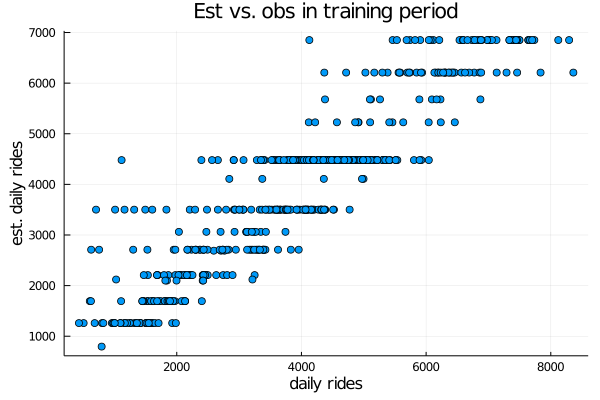

In [12]:
scatter(ytrain,ŷtrain,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in training period")

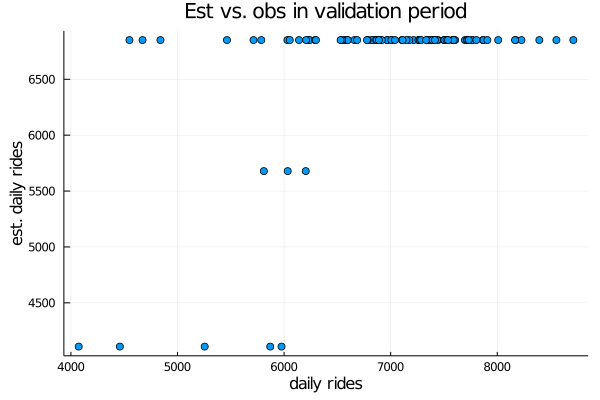

In [13]:
scatter(yval,ŷval,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in validation period")

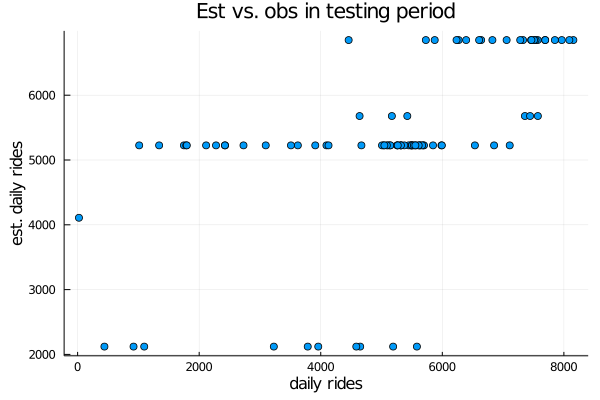

In [14]:
scatter(ytest,ŷtest,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in testing period")

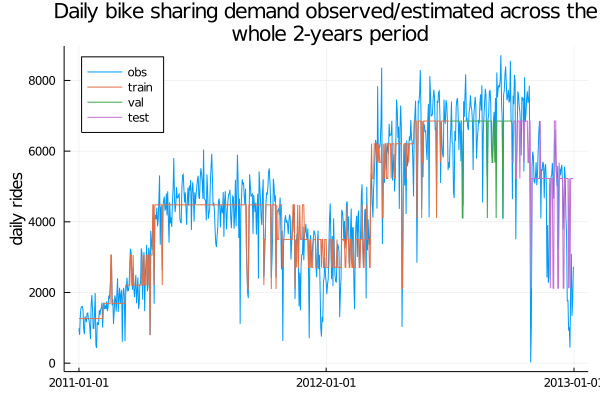

In [15]:
# Full period plot (2 years)
ŷtrainfull = vcat(ŷtrain,fill(missing,nval+ntest))
ŷvalfull = vcat(fill(missing,ntrain), ŷval, fill(missing,ntest))
ŷtestfull = vcat(fill(missing,ntrain+nval), ŷtest)
plot(data[:,:dteday],[data[:,:cnt] ŷtrainfull ŷvalfull ŷtestfull], label=["obs" "train" "val" "test"], legend=:topleft, ylabel="daily rides", title="Daily bike sharing demand observed/estimated across the\n whole 2-years period")

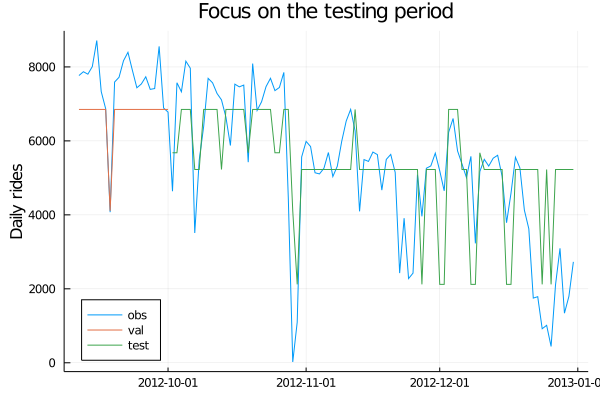

In [16]:
# Focus on testing data
stc = 620
endc = size(x,1)
plot(data[stc:endc,:dteday],[data[stc:endc,:cnt] ŷvalfull[stc:endc] ŷtestfull[stc:endc]], label=["obs" "val" "test"], legend=:bottomleft, ylabel="Daily rides", title="Focus on the testing period")

## Random forest

In [17]:
function findBestDepth(xtrain,ytrain,xval,yval,atteptedDepths)
    bestDepth = 1
    bestMre   = +Inf
    for ad in atteptedDepths
        myForest = buildForest(xtrain,ytrain, 20, max_depth=ad)
        ŷval   = Trees.predict(myForest, xval)
        mreVal = relative_mean_error(ŷval,yval)
        println("$ad : $mreVal")
        if mreVal < bestMre
            bestDepth = ad
            bestMre   = mreVal
        end
    end
    return (bestDepth, bestMre)
end

findBestDepth (generic function with 1 method)

In [18]:
bestDepth, bestMre = findBestDepth(xtrain,ytrain,xval,yval,1:30)

1 : 0.4109887476237305
2 : 0.2713845563489213
3 : 0.18503713404445002
4 : 0.1807046517426204
5 : 0.13306164086041292
6 : 0.13307760130262328
7 : 0.19294314294707685
8 : 0.12674661910292384
9 : 0.13379233469299465
10 : 0.12321197291167187
11 : 0.1219616810913042
12 : 0.13980241328573711
13 : 0.12880672744303376
14 : 0.1443567084400262
15 : 0.13791455174488237
16 : 0.15582602379402855
17 : 0.11143208005778751
18 : 0.12062405482459967
19 : 0.12368114956543336
20 : 0.1792042413842918
21 : 0.14529209125739137
22 : 0.13138000683486178
23 : 0.15918554506422236
24 : 0.12511157934092845
25 : 0.14566327819589545
26 : 0.09717868495196998
27 : 0.1622523663223821
28 : 0.12538119046980117
29 : 0.14613714364217642
30 : 0.12286445402590208


(26, 0.09717868495196998)

In [19]:
myForest = buildForest(convert(Matrix,xtrain),ytrain, 100, max_depth=bestDepth,β=0,oob=true)
oobError = myForest.oobError # note: Here the oob reported is different than the testing error. Why? Because the division between training/validation a,d testing is not random, but has a temporal basis. It seems in this example that data in validation/testing feel a different pattern/variance than those in training

0.158603655797714

In [20]:
ŷtrain = Trees.predict(myForest, xtrain)
ŷval   = Trees.predict(myForest, xval)
ŷtest  = Trees.predict(myForest, xtest)

91-element Array{Float64,1}:
 4517.796053763441
 5502.539774351677
 6093.775607685009
 6496.3884428104575
 6514.864851540616
 5043.319166666667
 4368.5825
 5287.529333333334
 6212.710387254902
 6095.972827731092
 6119.799494397759
 5146.529970588236
 6143.743380952381
    ⋮
 4518.723444272447
 3659.5965
 3708.3513636363637
 4102.74453030303
 3440.5827777777777
 3720.892333333333
 2646.3608333333336
 3404.840166666667
 3731.651
 3541.1533333333336
 3565.2113636363633
 3591.5426666666663

In [21]:
updateTreesWeights!(myForest,xtrain,ytrain,β=500)

100-element Array{Float64,1}:
 5.456620639278209e-49
 2.2070351651057209e-44
 1.6912003213681219e-40
 1.6609391893872417e-48
 1.7683391312797328e-55
 1.3345865384286014e-49
 1.0805911227696453e-54
 2.2742172817111438e-45
 2.584906909570293e-47
 4.462809132458992e-51
 6.370655148018675e-60
 1.149763601443719e-54
 2.5145290936246987e-54
 ⋮
 9.816246163523924e-52
 8.309646000782073e-54
 8.454321752967116e-45
 1.410353902818583e-49
 6.738521513126491e-53
 5.233549063125107e-43
 4.696465326371796e-49
 2.8179202869283086e-45
 4.3771939602677714e-48
 7.828863971865161e-48
 1.0089983948022606e-49
 1.2493038625015382e-47

In [22]:
ŷtrain2 = Trees.predict(myForest, xtrain)
ŷval2   = Trees.predict(myForest, xval)
ŷtest2  = Trees.predict(myForest, xtest)

91-element Array{Float64,1}:
 1027.0361474692806
 6882.986679656601
 6879.003359676749
 6878.99992950393
 7334.9879095000915
 6303.996608828158
 5102.00610783202
 5025.998313298049
 7334.99036973343
 6427.996827571098
 6427.996944530954
 6234.99419419046
 6997.992460974252
    ⋮
 6427.987820371977
 3922.0008947418373
 3955.9991472789457
 3956.0001743131993
 2336.999916506036
 3922.0056112290035
 1834.0028510782065
 2337.0113274207984
 2337.0153913847853
 2337.017657311181
 3955.9984939265123
 2337.014743383637

In [23]:
(mreTrain, mreVal, mreTest) = mean_relative_error.([ŷtrain,ŷval,ŷtest],[ytrain,yval,ytest])

3-element Array{Float64,1}:
 0.061340989986967666
 0.1398347106040521
 2.283392176250092

In [24]:
(mreTrain2, mreVal2, mreTest2) = mean_relative_error.([ŷtrain2,ŷval2,ŷtest2],[ytrain,yval,ytest])

3-element Array{Float64,1}:
 0.06567330365973341
 0.1112559662477595
 0.896006240813744

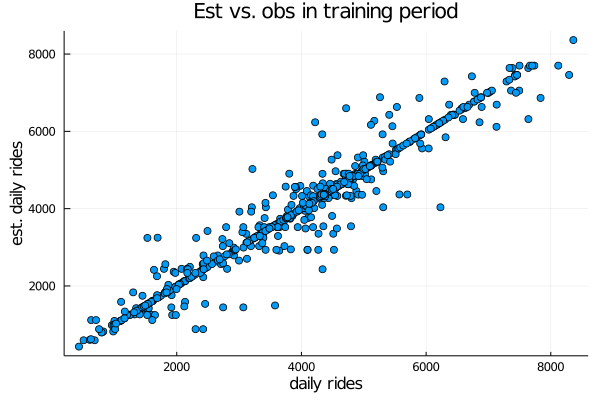

In [25]:
scatter(ytrain,ŷtrain2,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in training period")

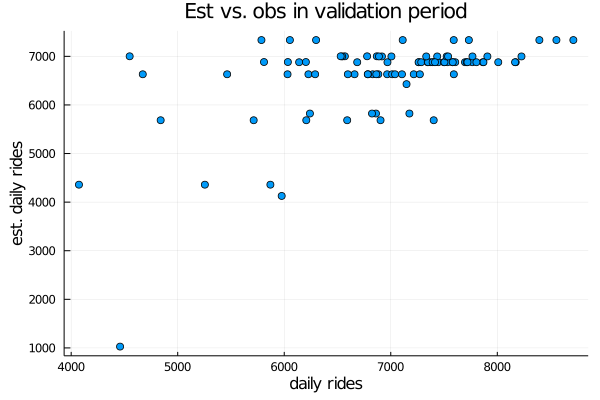

In [26]:
scatter(yval,ŷval2,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in validation period")

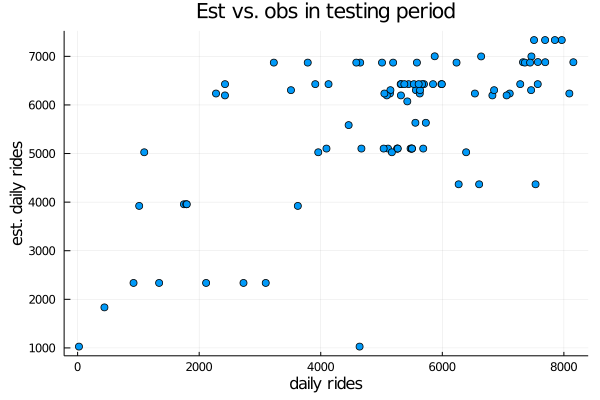

In [27]:
scatter(ytest,ŷtest2,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in testing period")

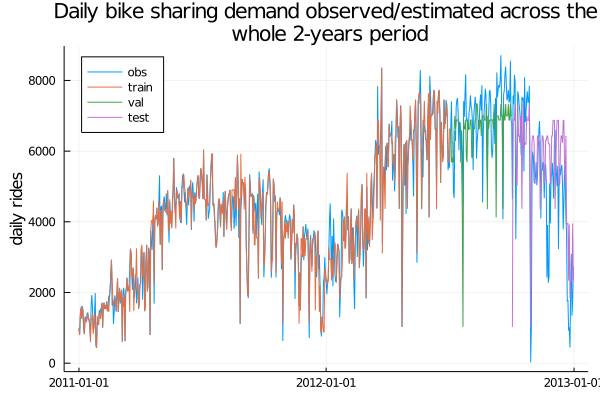

In [28]:
# Full period plot (2 years)
ŷtrainfull = vcat(ŷtrain2,fill(missing,nval+ntest))
ŷvalfull = vcat(fill(missing,ntrain), ŷval2, fill(missing,ntest))
ŷtestfull = vcat(fill(missing,ntrain+nval), ŷtest2)
plot(data[:,:dteday],[data[:,:cnt] ŷtrainfull ŷvalfull ŷtestfull], label=["obs" "train" "val" "test"], legend=:topleft, ylabel="daily rides", title="Daily bike sharing demand observed/estimated across the\n whole 2-years period")

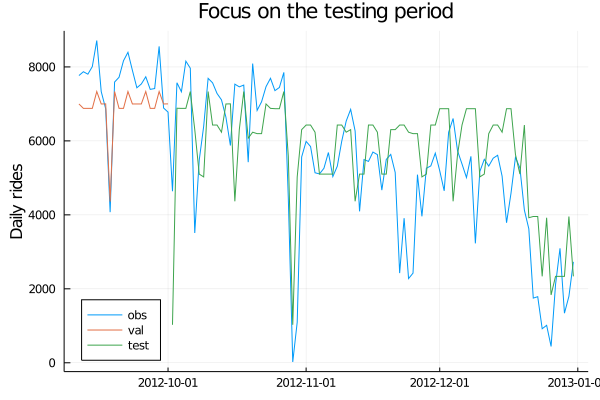

In [29]:
# Focus on testing data
stc = 620
endc = size(x,1)
plot(data[stc:endc,:dteday],[data[stc:endc,:cnt] ŷvalfull[stc:endc] ŷtestfull[stc:endc]], label=["obs" "val" "test"], legend=:bottomleft, ylabel="Daily rides", title="Focus on the testing period")

# Comparision with DecisionTree

In [30]:
n_subfeatures=-1; n_trees=30; partial_sampling=1; max_depth=26
min_samples_leaf=2; min_samples_split=2; min_purity_increase=0.0; seed=3

model = build_forest(ytrain, convert(Matrix,xtrain),
                     n_subfeatures,
                     n_trees,
                     partial_sampling,
                     max_depth,
                     min_samples_leaf,
                     min_samples_split,
                     min_purity_increase;
                     rng = seed)

Ensemble of Decision Trees
Trees:      30
Avg Leaves: 214.06666666666666
Avg Depth:  9.233333333333333

In [31]:
ŷtrain = apply_forest(model,convert(Matrix,xtrain))
ŷval = apply_forest(model,convert(Matrix,xval))
ŷtest = apply_forest(model,convert(Matrix,xtest))

91-element Array{Int64,1}:
 5099
 6073
 6770
 7639
 5202
 2765
 5099
 2765
 4195
 6398
 5918
 4220
 4195
    ⋮
 3194
 1683
 4118
 3422
 3620
 2947
 3613
 2169
 2947
 2832
 3333
 2431

In [32]:
(mreTrain, mreVal, mreTest) = mean_relative_error.([ŷtrain,ŷval,ŷtest],[ytrain,yval,ytest])

3-element Array{Float64,1}:
 0.001156034676466192
 0.1886198701933334
 2.9653481297558595